# RUN

In [66]:
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from nilearn.decoding import Decoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC 

from nilearn.image import clean_img
from nilearn.maskers import NiftiMasker
from nilearn.masking import compute_brain_mask
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_roi
from nilearn import plotting


from fonction import *
from run_ import *

# Load data

In [3]:
# load beta images
# And clean them, replacing nans by 0s ...

beta_maps_dir = 'data/beta_maps'
beta_maps = []
for file in sorted(os.listdir(beta_maps_dir)):
    if file.endswith('.nii.gz'):
        map = nib.load(os.path.join(beta_maps_dir, file))
        beta_maps.append(clean_img(map, standardize=False, ensure_finite=True))

nb_sub = len(beta_maps)

print('Number of subjects: ', nb_sub)

Number of subjects:  49


# Mask data

Shape of the mask:  (91, 109, 91)


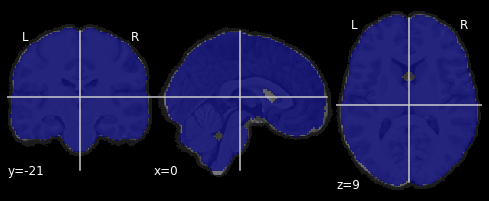

In [5]:
anat_path = 'data/anatomy/mask.nii'
anatomy = nib.load(anat_path)
mask = compute_brain_mask(anatomy, threshold = 0.3)
anat = 'data/anatomy/average_T1_51subs_FE.nii'
print('Shape of the mask: ', mask.shape)
plot_roi(mask, anat)


In [6]:
masker = NiftiMasker(mask_img=mask)

samples = []
for map in tqdm(beta_maps):
    samples.append(masker.fit_transform(map))
samples = np.concatenate(samples, axis=0)

100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


In [7]:
print("We have 49 subjects, and for each of them there are 30 beta maps. Hence we have", samples.shape[0],
      "observations and",  samples.shape[1], "features")

We have 49 subjects, and for each of them there are 30 beta maps. Hence we have 1470 observations and 233691 features


# Labels

In [8]:
random.seed(42)

In [9]:
labels = np.tile(['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit'], 5*49)
print('Numbers of labels/training samples: ', len(labels))

Numbers of labels/training samples:  1470


In [10]:
train_samples, test_samples, train_labels, test_labels = split(samples, labels, 4)

Test sample shape (120, 233691) , label size :  120
Train sample shape (1350, 233691) , label size :  1350


# Classification

# Part 1 - Simple MVPA approach 

Evaluation of model and cross fold strategy to predict condition (just evluate that all vowels in the mask allow the classification of the condition).

2 models : 
- Logistic Classifier : with mutlinomial
- SVC : with ovr (one vs the rest)

3 CV strategy : 
- 5-fold CV
- leave 1 run out across all subjects
- leave a set of subject (7*9) across all subject 


https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_nilearn.html

--> All model evaluate with Accuracy

In [11]:
chunks_CV = {}
for key in ['per_9subjects', 'per_run'] :
    chunks_CV[key]=eval('make_chunks_'+key)()

## Baseline Models

In [12]:
classifiers = {'logistic': LogisticRegression(multi_class="multinomial", max_iter=50), 'svc' : LinearSVC(max_iter=50)}

In [13]:
dic_cv_scores={}
baseline_run(classifiers, chunks_CV, train_samples, train_labels, dic_cv_scores)


logistic, 5fold_CV :


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Average accuracy = 0.78 

Average Accuracy std = 0.04 

Accuracy per fold:
[0.71481481 0.77037037 0.80740741 0.77037037 0.81851852]

logistic,per_9subjects :


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   57.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Average accuracy = 0.78 

Average Accuracy std = 0.03 


logistic,per_run :


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   59.6s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Average accuracy = 0.81 

Average Accuracy std = 0.03 


svc, 5fold_CV :


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Average accuracy = 0.69 

Average Accuracy std = 0.03 

Accuracy per fold:
[0.62592593 0.67777778 0.72962963 0.68888889 0.70740741]

svc,per_9subjects :


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


Average accuracy = 0.70 

Average Accuracy std = 0.05 


svc,per_run :


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min


Average accuracy = 0.74 

Average Accuracy std = 0.04 



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


### Visualisation

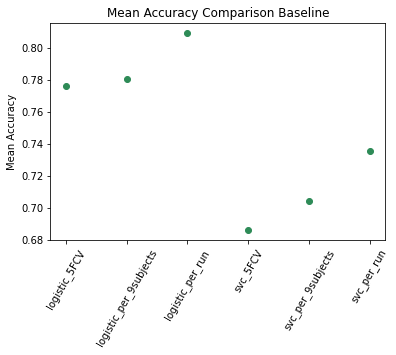

In [15]:
for key,mean in dic_cv_scores.items():
    plt.scatter(key,mean,color='seagreen')
    
plt.xticks(rotation=60)
plt.title('Mean Accuracy Comparison Baseline')
plt.ylabel('Mean Accuracy')
plt.show()

### Evaluation on test data

Test accuracy Score for  logistic  :  0.7083333333333334 

F1 score for logistic : [0.66666667 0.66666667 0.84210526 0.69767442 0.68085106 0.70588235]


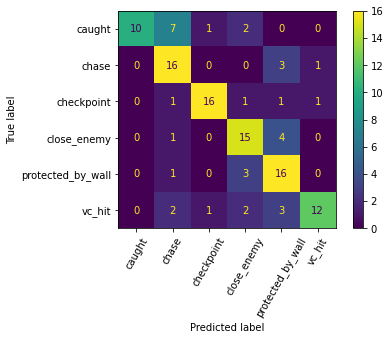

Test accuracy Score for  svc  :  0.6166666666666667 

F1 score for svc : [0.26086957 0.61538462 0.82051282 0.60465116 0.61016949 0.64864865]


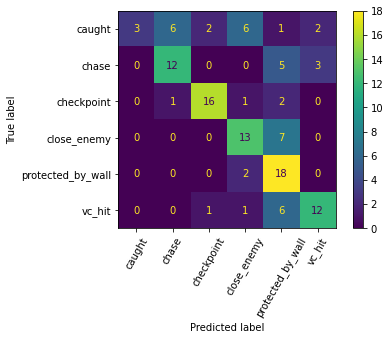

In [18]:
test_baseline(train_samples,test_samples,train_labels, test_labels,classifiers)

*Conclusion* : The logistic Classifier works faster, and achieve better classification with all CV strategies but also with the testdataset. Hence, we will conitnue only with it and try to improve the accuracy by tunning the hyperparameters and test for feqtures extraction.

## Tuned Model

In [19]:
logic_score={}
gid_logistic = {'logistic__C' : [1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]}

In [20]:
pipe = Pipeline([('scale', StandardScaler()), ('logistic', LogisticRegression(multi_class="multinomial",max_iter=50))])
tuned_run(pipe, gid_logistic,chunks_CV, train_samples, train_labels, '_tuned', logic_score, 'logistic')


logistic, 5fold CV : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.80222222 0.79703704 0.78740741 0.77925926 0.77925926 0.7762963 ] 

Test score std  : [0.03587817 0.02745741 0.0314793  0.03309379 0.03301079 0.03633407] 

Best Score:  0.8022222222222222
Best Params:  {'logistic__C': 1e-05}

logistic , per_9subjects : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Mean test score : [0.8        0.80222222 0.79259259 0.78444444 0.78222222 0.78074074] 

Test score std  : [0.03458553 0.02583051 0.02490035 0.02494438 0.02538051 0.02695319] 

Best Score:  0.8022222222222222
Best Params:  {'logistic__C': 0.0001}

logistic , per_run : 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mean test score : [0.82592593 0.81925926 0.81333333 0.81185185 0.81333333 0.80962963] 

Test score std  : [0.04952449 0.03699257 0.03350573 0.03477539 0.03059537 0.02625192] 

Best Score:  0.825925925925926
Best Params:  {'logistic__C': 1e-05}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

### Visualisation

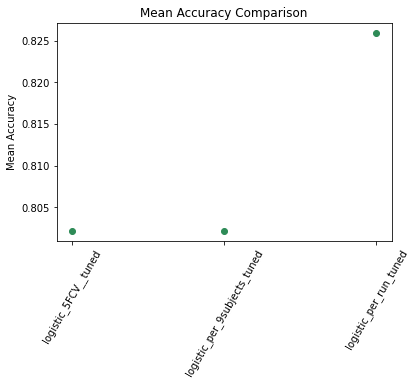

In [21]:
for key,mean in logic_score.items():
    plt.scatter(key,mean,color='seagreen')
    
plt.xticks(rotation=60)
plt.title('Mean Accuracy Comparison')
plt.ylabel('Mean Accuracy')
plt.show()

## Evaluation of the Best Model : Permutation Test

---> compare the accuracy value of the correct labels to the ones with random/false labels

In [22]:
clf= LogisticRegression(multi_class="multinomial", max_iter=50, C=1e-5)
pipeline = Pipeline([('scale', StandardScaler()), ('logistic', clf)])

In [23]:
evaluation_test(pipeline, train_samples, train_labels, LeaveOneGroupOut(), chunks_CV['per_run'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Prediction accuracy : 0.83 
 p-value: 0.0323


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.9min finished


*NB* :  p-value --> the lower the better  : bc it's indicate that there's a dependency btw the features & targets which has been used by the estimator to give good prediction.

*Conclusion* : use CV with per_run 

# 2nd Part  : Decoding
With the best model & CV strategy selected above, we now search for visualisaing which area of the brain is involved into the condition. 
https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_decoding_tutorial.html#sphx-glr-auto-examples-00-tutorials-plot-decoding-tutorial-py

In [24]:
beta_maps_test = nib.funcs.concat_images(beta_maps[0:4], axis = -1)
beta_maps_train = nib.funcs.concat_images(beta_maps[4:49], axis = -1)
labels_test = labels[:120]
labels_train = labels[120:,]

In [108]:
best_grid = {'C': [1e-5], 
             'solver' : ['lbfgs'], 
             'multi_class':['multinomial'],
             'max_iter':[100] }

In [109]:
 warnings.simplefilter("ignore")
decoder = Decoder(estimator= 'logistic',mask= mask, param_grid=best_grid, 
                  cv=LeaveOneGroupOut(),scoring='accuracy', standardize = True)

decoder.fit(beta_maps_train, train_labels, chunks_CV['per_run'])

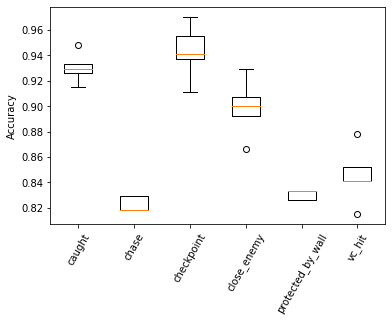

In [110]:
fig, ax = plt.subplots()
ax.boxplot(decoder.cv_scores_.values())
ax.set_xticklabels(decoder.cv_scores_.keys())
plt.xticks(rotation=60)
plt.ylabel('Accuracy')
plt.show()

Test accuracy Score  :  0.7333333333333333 



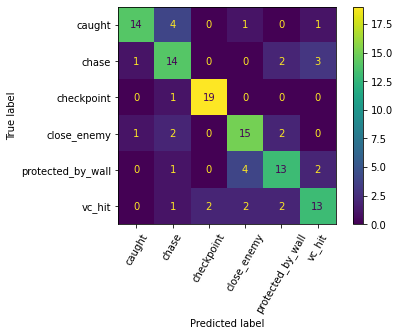

In [111]:
# Prediction
test_pred = decoder.predict(beta_maps_test)
acc =accuracy_score(labels_test, test_pred)
print('Test accuracy Score  : ',  acc, '\n')   
cm=confusion_matrix(labels_test, test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decoder.classes_)
disp.plot()
plt.xticks(rotation=60)
plt.show()

# Plots

In [112]:
import matplotlib.pyplot as plt
import os

plot_directory = './plots'
os.makedirs(plot_directory, exist_ok = True)
classes = ['caught', 'chase', 'checkpoint', 'close_enemy', 'protected_by_wall', 'vc_hit']

In [116]:
for class_ in classes:
	plotting.plot_stat_map(decoder.coef_img_[class_],title=class_ +  " Logistic weights", output_file = os.path.join(plot_directory, class_ + '.png'))

### Removing mean/median

In [117]:
weights = []
for class_ in classes:
	weights.append(decoder.coef_img_[class_].get_fdata())
mean_weights = np.array(weights).mean(axis=0)
median_weights = np.median(np.array(weights), axis=0)

In [118]:
for class_ in classes:
	current_coefs = decoder.coef_img_[class_]
	weights, affine = current_coefs.get_fdata(), current_coefs.affine
	img_minus_mean = nib.Nifti1Image(weights - mean_weights, affine)
	img_minus_median = nib.Nifti1Image(weights - median_weights, affine)
	
	plotting.plot_stat_map(img_minus_mean,title=class_ +  " Logistic weights minus mean", output_file = os.path.join(plot_directory, class_ + '_contrast_mean.png'))
	plotting.plot_stat_map(img_minus_median,title=class_ +  " Logistic weights minus median", output_file = os.path.join(plot_directory, class_ + '_contrast_median.png'))


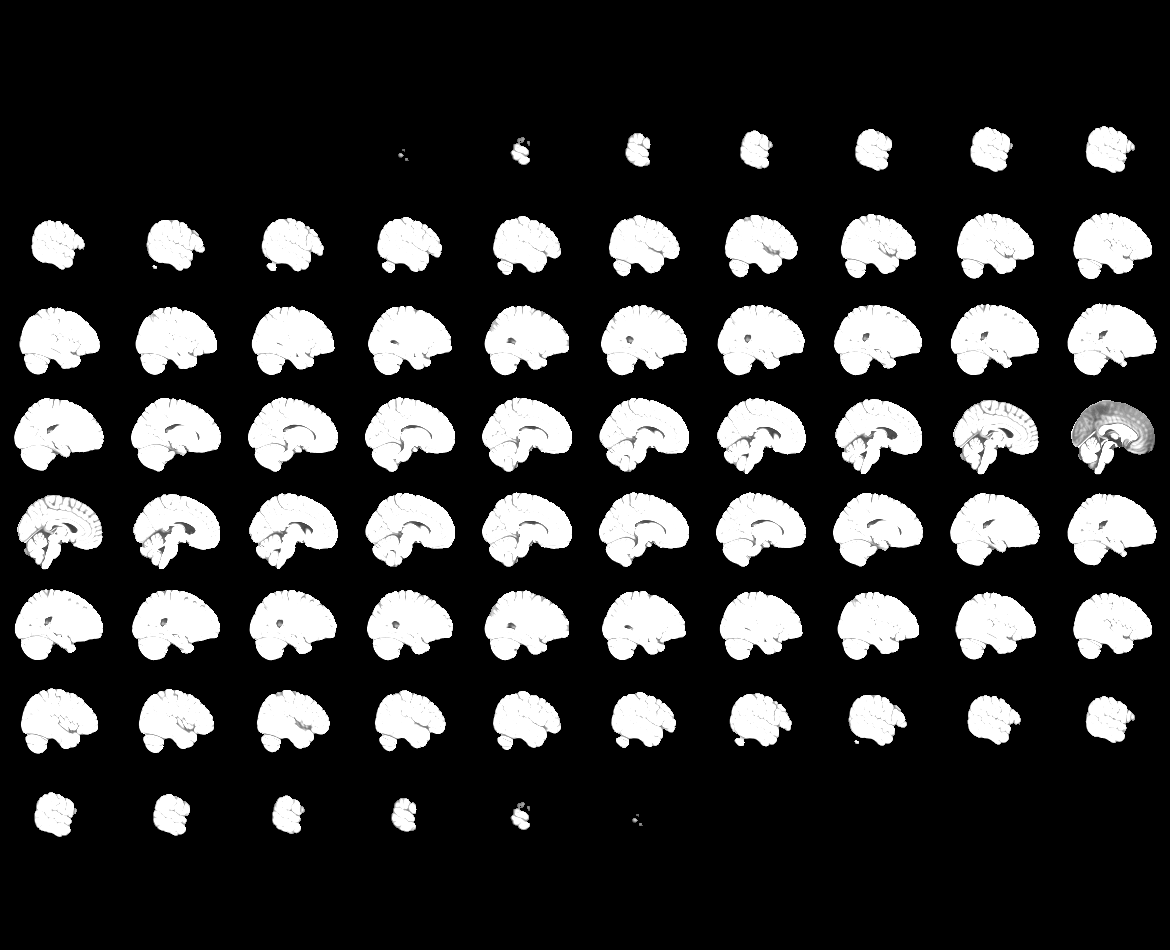
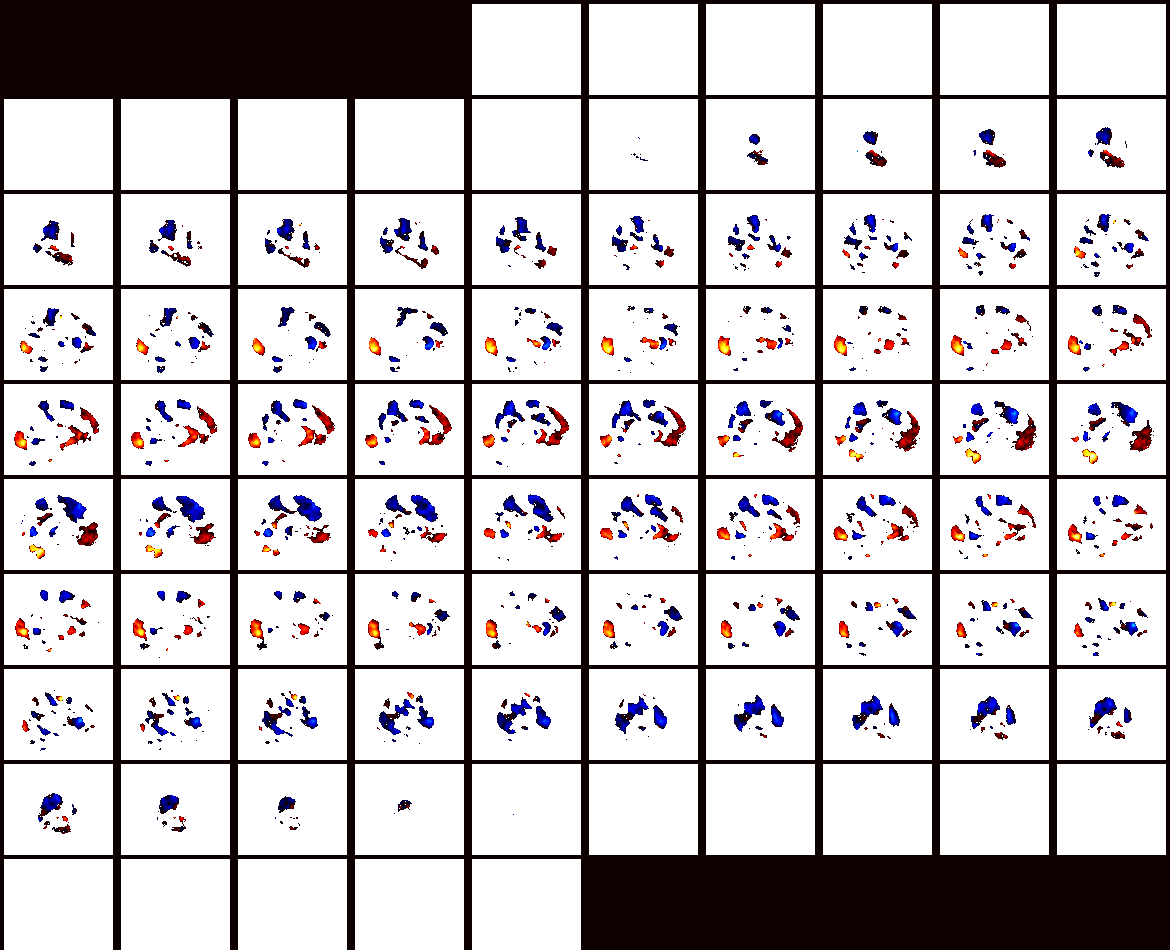

In [88]:
plotting.view_img(decoder.coef_img_['checkpoint'],title=" checkpoint Logistic weights", dim=-1)


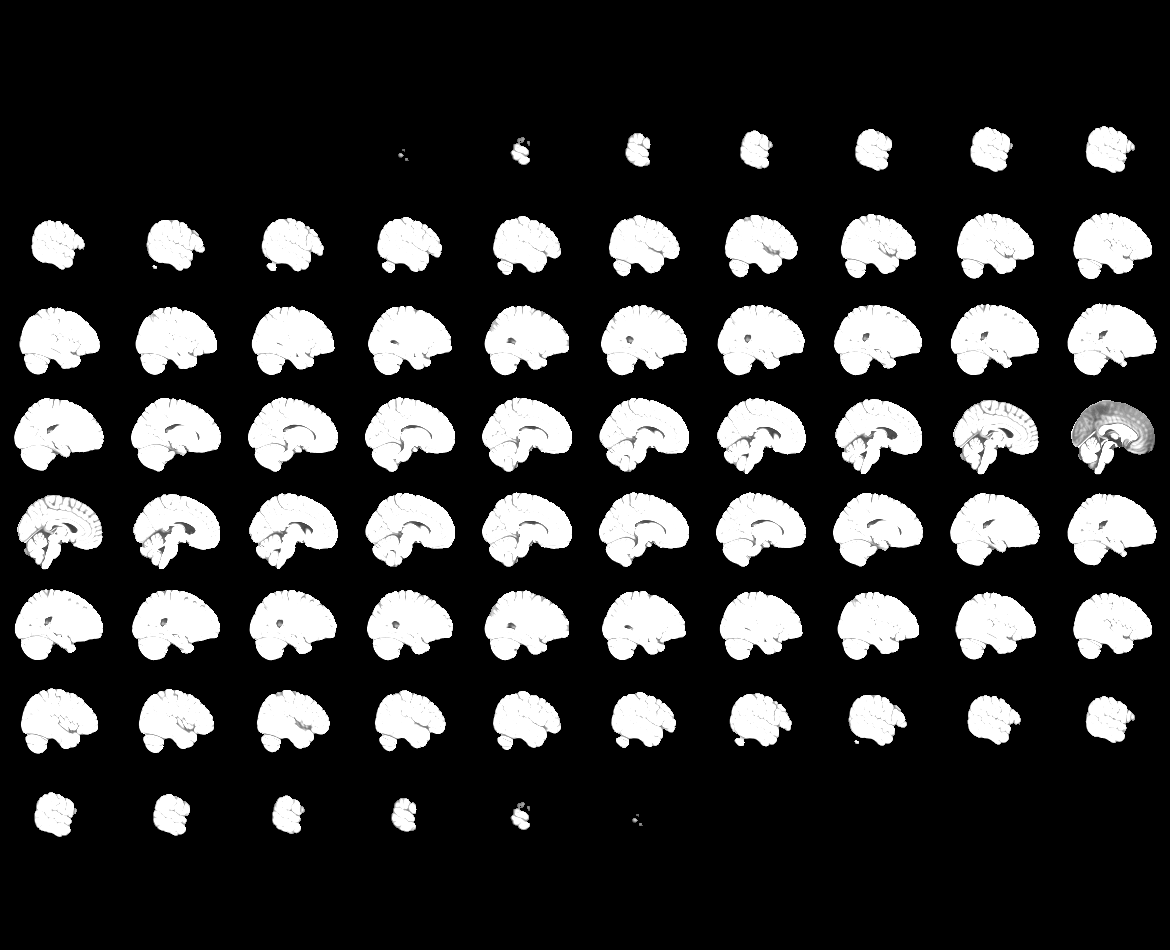
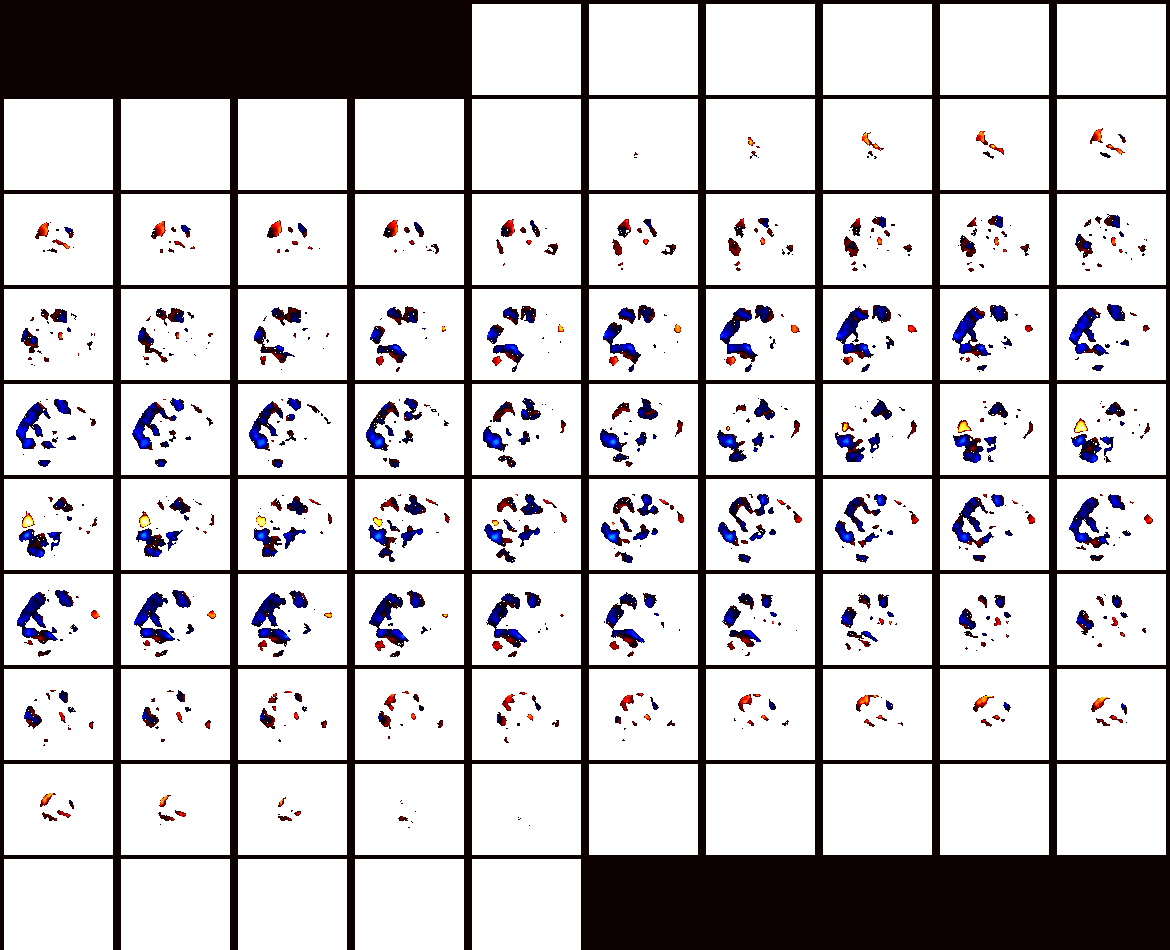

In [89]:
plotting.view_img(decoder.coef_img_['close_enemy'],title=" close_enemy Logistic weights", dim=-1)


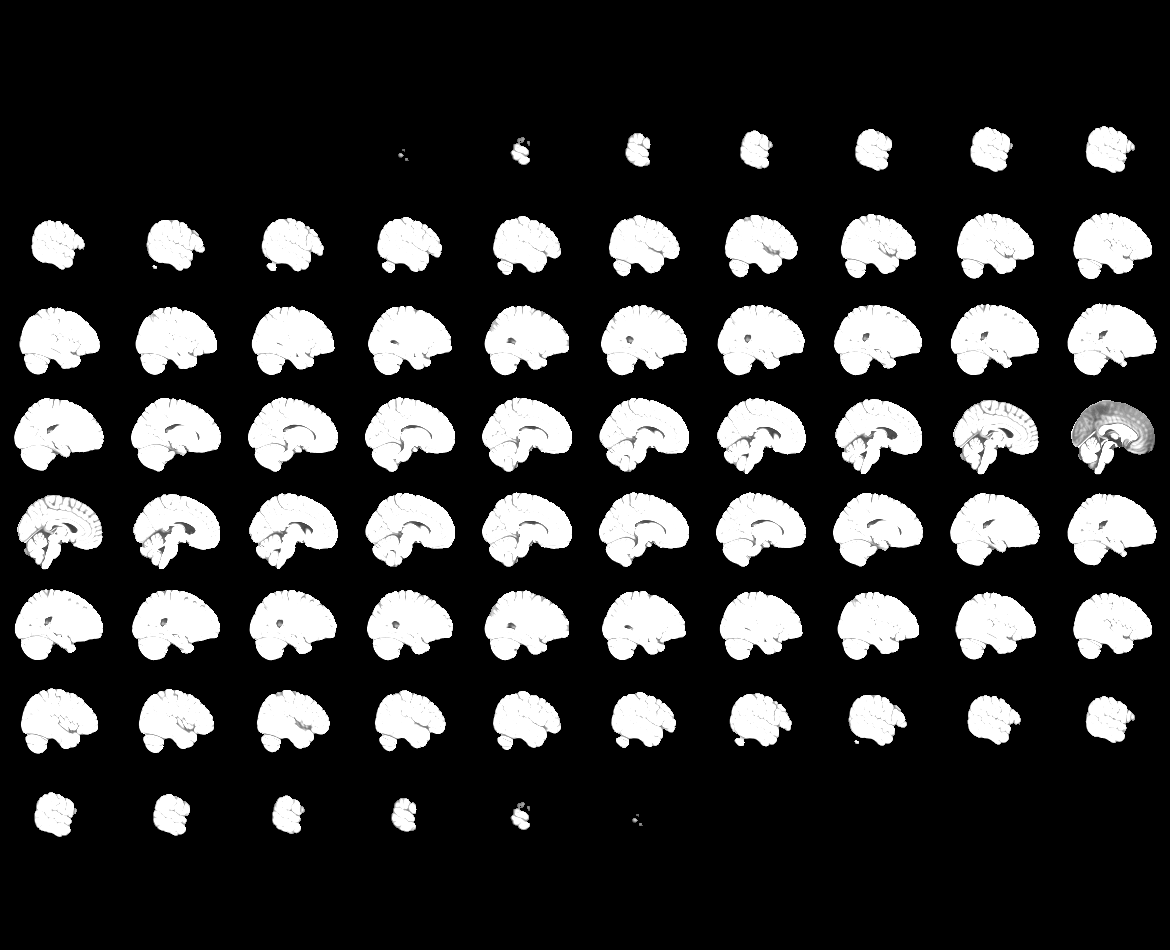
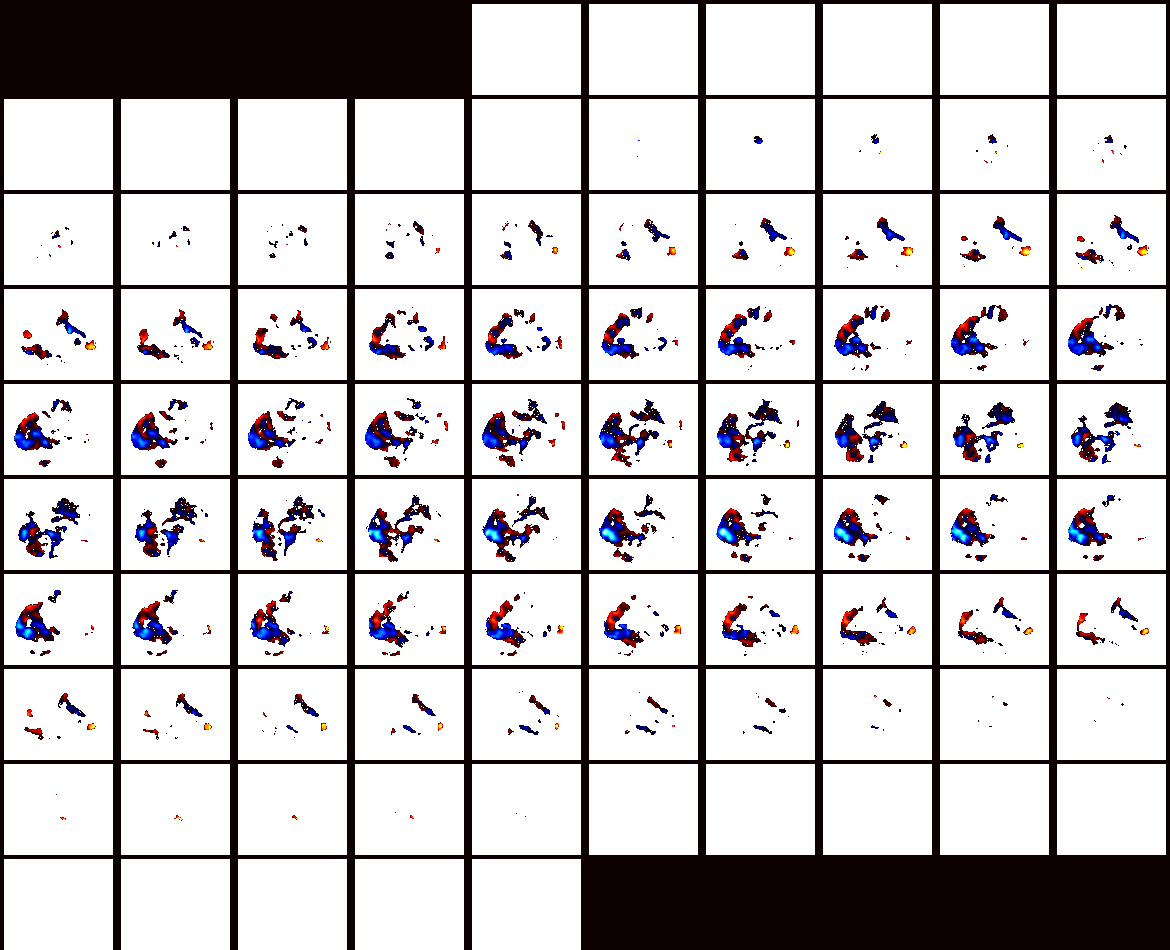

In [90]:
plotting.view_img(decoder.coef_img_['protected_by_wall'], title=" Protected_by_wall Logstic weights", dim=-1)


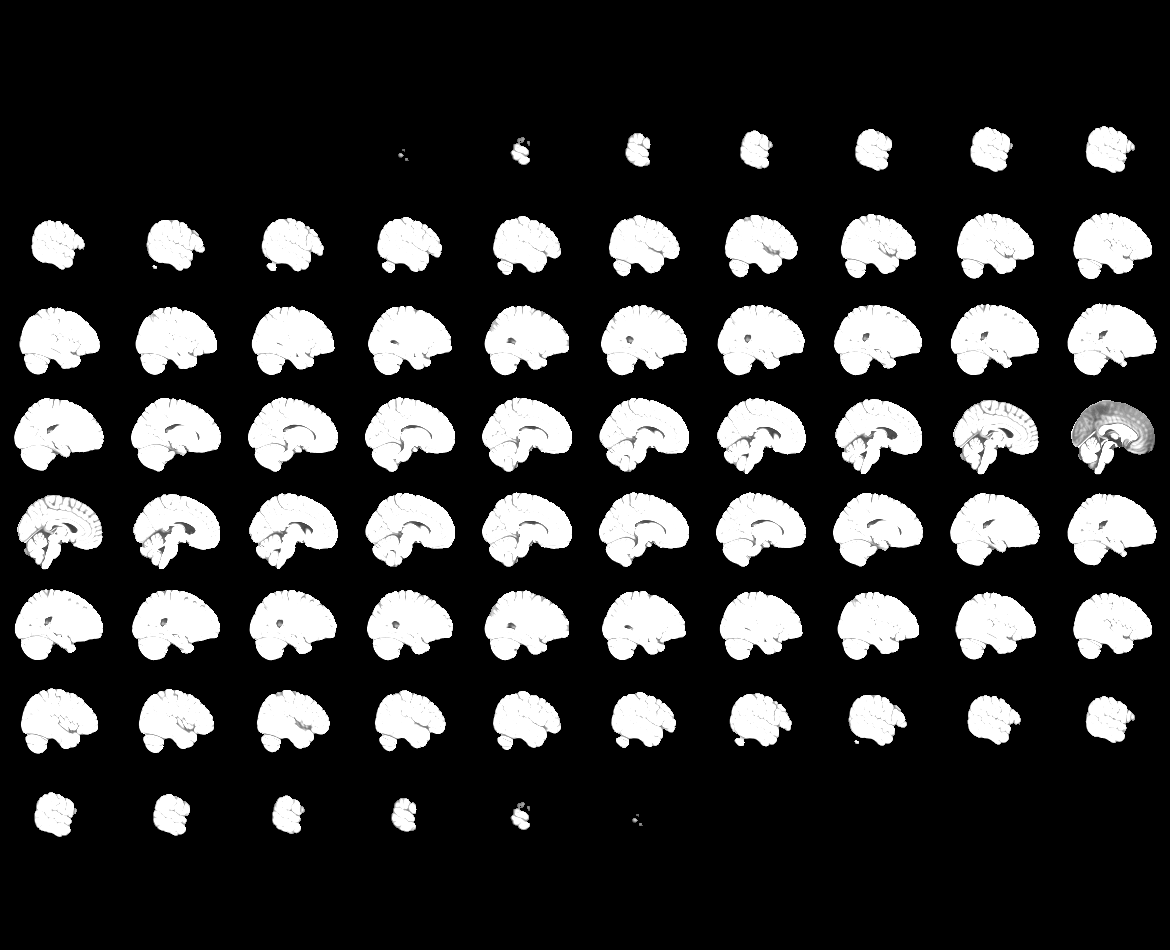
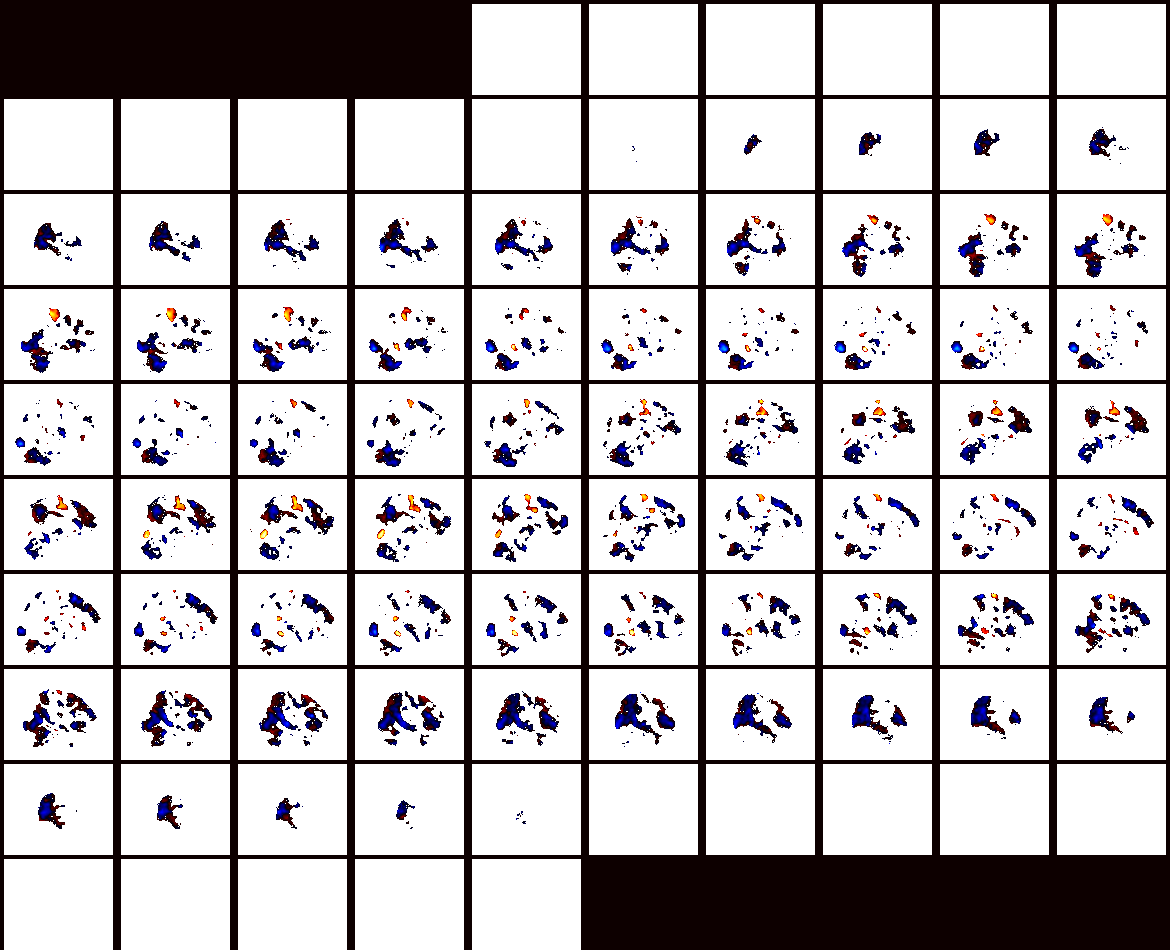

In [91]:
plotting.view_img(decoder.coef_img_['vc_hit'], title=" vc_hit Logstic weights", dim=-1)

In [51]:
def mean_of_weights_per_class(dec):
	weights_per_class = dec.coef_img_
	avg = 0
	for el in weights_per_class.values():
		avg += el.get_fdata()
	return avg / len(weights_per_class)


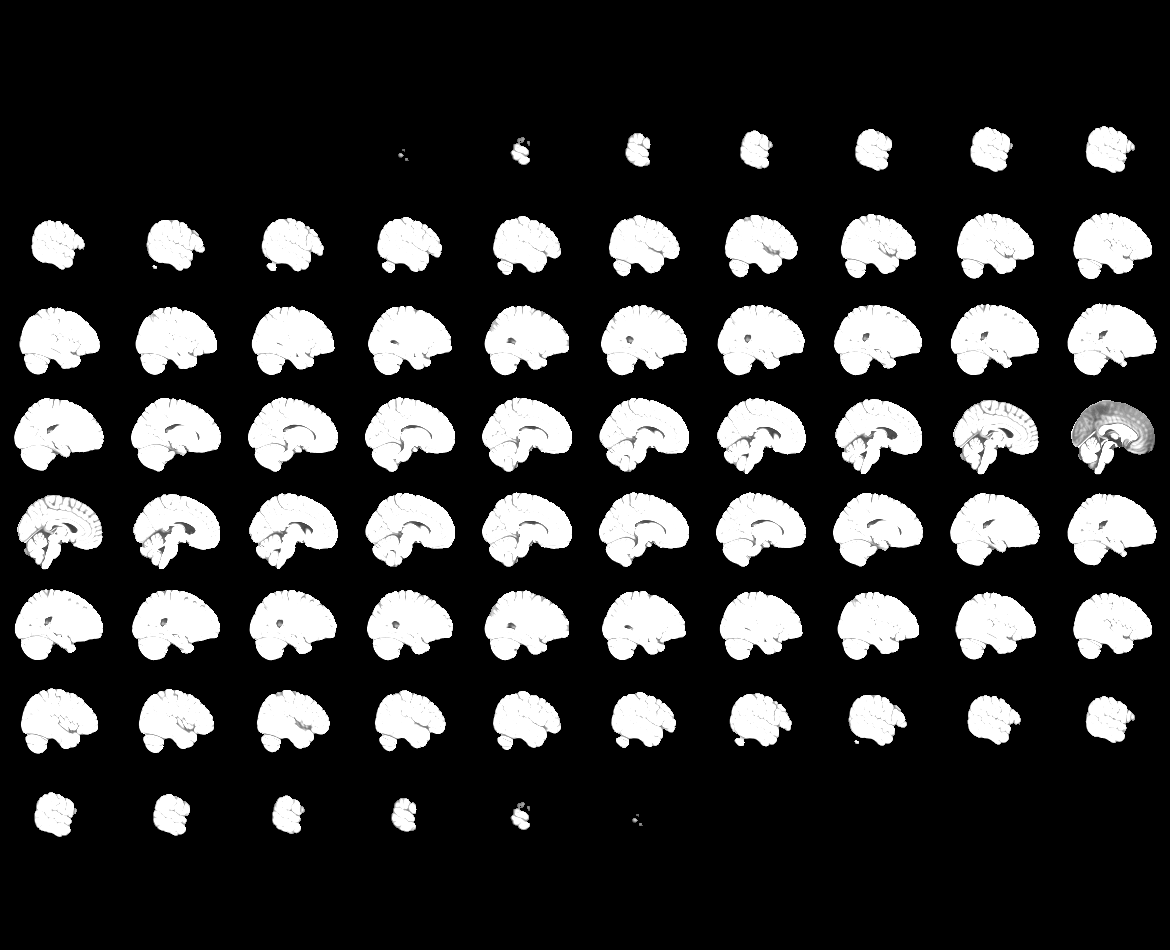
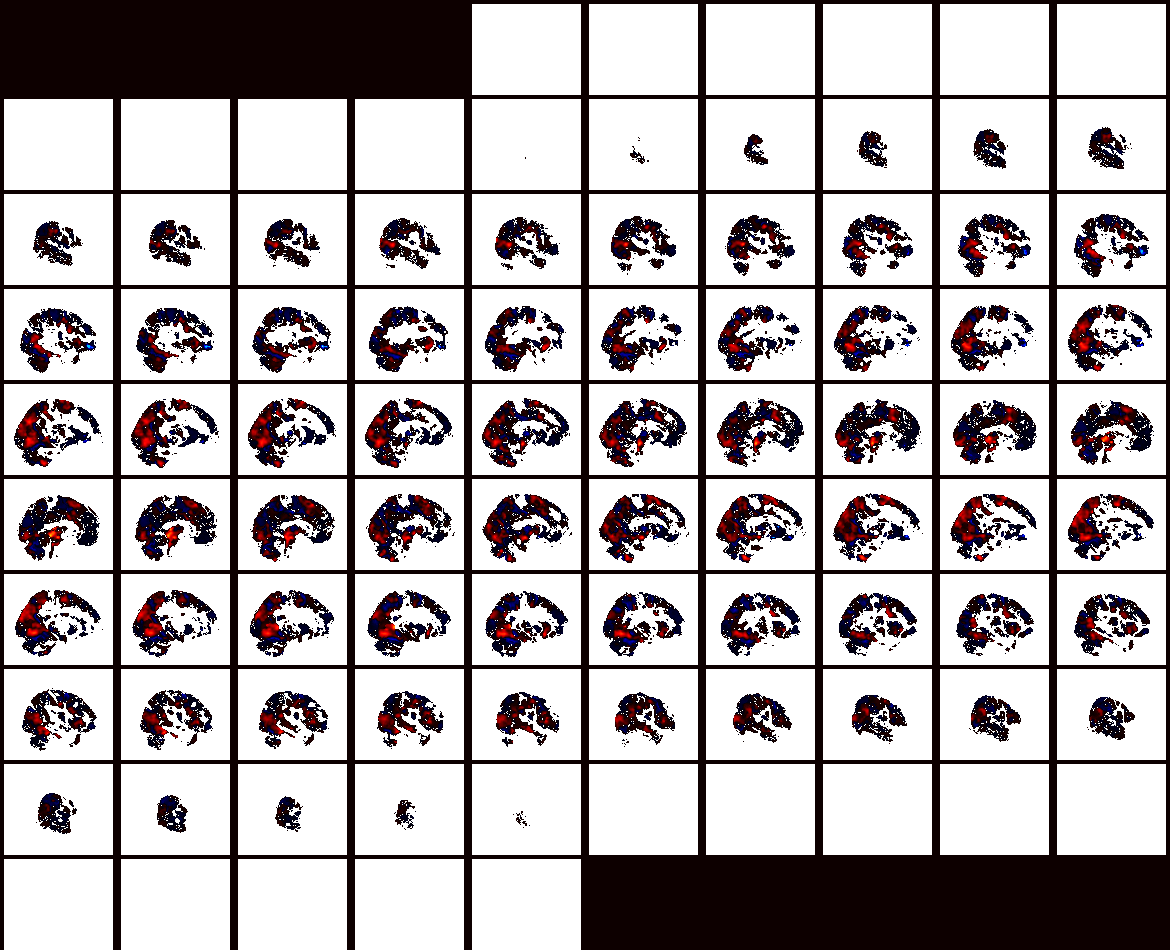

In [61]:
affine = decoder.coef_img_['chase'].affine
img = nib.Nifti1Image(decoder.coef_img_['caught'].get_fdata() - mean_of_weights_per_class(decoder), affine)
plotting.view_img(img, title=" vc_hit Logstic weights", dim=-1)

## Verify it performs better than a dummy classifier 

In [36]:
warnings.simplefilter("ignore")
dummy_decoder = Decoder(estimator='dummy_classifier', mask=mask,
                        cv=LeaveOneGroupOut(),scoring='accuracy', standardize =True)
dummy_decoder.fit(beta_maps_train, train_labels, chunks_CV['per_run'])

In [48]:
print(dummy_decoder.cv_scores_.values())

dict_values([[0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222], [0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445], [0.7518518518518519, 0.7518518518518519, 0.7518518518518519, 0.7518518518518519, 0.7518518518518519], [0.7296296296296296, 0.7296296296296296, 0.7296296296296296, 0.7296296296296296, 0.7296296296296296], [0.7148148148148148, 0.7148148148148148, 0.7148148148148148, 0.7148148148148148, 0.7148148148148148], [0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445, 0.7444444444444445]])


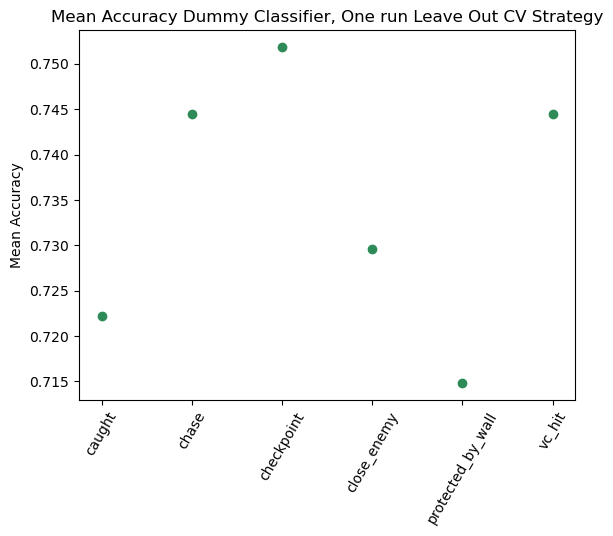

In [57]:
for key,err in dummy_decoder.cv_scores_.items():
    plt.scatter(key,np.mean(err),color='seagreen')
    
plt.xticks(rotation=60)
plt.title('Mean Accuracy Dummy Classifier, One run Leave Out CV Strategy')
plt.ylabel('Mean Accuracy')
plt.show()

Test accuracy Score  :  0.21666666666666667 



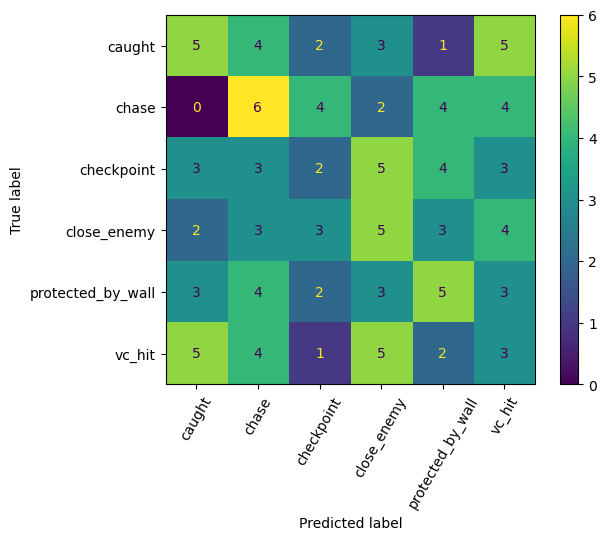

In [36]:
test_pred = dummy_decoder.predict(beta_maps_test)
acc_dummy=accuracy_score(labels_test, test_pred)
print('Test accuracy Score  : ',  acc_dummy, '\n')   
cm=confusion_matrix(labels_test, test_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy_decoder.classes_)
disp.plot()
plt.xticks(rotation=60)
plt.show()